In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from PFNExperiments.LinearRegression.GenerativeModels.Curriculum import Curriculum
from PFNExperiments.LinearRegression.GenerativeModels.GenerateDataCurriculumCFM import GenerateDataCurriculumCFM
from PFNExperiments.LinearRegression.Models.Transformer_CNF import TransformerCNFConditionalDecoder
from PFNExperiments.Training.FlowMatching.CFMLossOT2 import CFMLossOT2
from PFNExperiments.LatentFactorModels.Training.TrainerCurriculumCNF_LatentFactor import TrainerCurriculumCNF_LatentFactor
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
from PFNExperiments.LinearRegression.Models.ModelToPosteriorCNF import ModelToPosteriorCNF
from PFNExperiments.LatentFactorModels.ComparisonModels.Hamiltionian_MC import Hamiltionian_MC
from PFNExperiments.Evaluation.Evaluate import Evaluate, results_dict_to_data_x_tuple, result_dict_to_latent_variable_convert_mu_sigma_to_beta, results_dict_to_data_x_tuple_transpose, result_dict_to_latent_variable_convert_z_to_beta

In [3]:
from PFNExperiments.LatentFactorModels.GenerativeModels.FactorAnalysis.BasicFA import make_fa_program_normal_weight_prior, make_fa_program_normal_weight_prior_batched
from PFNExperiments.LatentFactorModels.GenerativeModels.LatenFactorModel_abstract import return_only_x

from PFNExperiments.LatentFactorModels.ComparisonModels.MakeDefaultListComparison import make_default_list_comparison, make_reduced_list_comparison


In [4]:
N = 10
P = 5
K = 3
BATCH_SIZE = 1024
N_EPOCHS = 100
N_SAMPLES_PER_EPOCH = 500_000
N_BATCHES_PER_EPOCH = N_SAMPLES_PER_EPOCH//BATCH_SIZE

In [5]:
curriculum = Curriculum(max_iter=int(N_EPOCHS*N_BATCHES_PER_EPOCH*BATCH_SIZE*0.5))
curriculum.add_param_list([
    ("n", curriculum.constant_scheduler(N)),
    ("p", curriculum.constant_scheduler(5)),
    ("batch_size", curriculum.constant_scheduler(BATCH_SIZE)),
    ("z_dim", curriculum.constant_scheduler(3)),
    ("w_var", curriculum.constant_scheduler(1.0)),
    ("mu_var", curriculum.constant_scheduler(1.0)),
    ("a1_psi_var", curriculum.constant_scheduler(5.0)),
    ("b1_psi_var", curriculum.constant_scheduler(2.0)),
])
#curriculum.plot_all_schedules()

In [6]:
data_generator = GenerateDataCurriculumCFM(
    pprogram_maker= make_fa_program_normal_weight_prior_batched,
    curriculum= curriculum,
)

pprogram_covariates_train is None, using pprogram_covariates instead
pprogram_covariates_val is None, using pprogram_covariates instead
pprogram_covariates_test is None, using pprogram_covariates instead


In [7]:
epoch_loader = data_generator.make_epoch_loader(
    n = N,
    p = P,
    number_of_batches_per_epoch = N_BATCHES_PER_EPOCH,
    n_epochs = N_EPOCHS,
    batch_size= BATCH_SIZE,
    train_frac= 0.5,
    val_frac= 0.1,
    shuffle=False,
    n_samples_to_generate_at_once = 250_000
    )

The number of batches times the number of epochs must be equal to the total number of iterations in the curriculum. But got 49971200 and 24985600 respectively


In [8]:
sample_batch = next(iter(epoch_loader[0][0]))

In [9]:
for key, value in sample_batch.items():
    print(key, value.shape)

x torch.Size([1024, 10, 5])
z torch.Size([1024, 3])
mu torch.Size([1024, 5])
w torch.Size([1024, 12])
psi torch.Size([1024, 5])
beta torch.Size([1024, 3])
time torch.Size([1024])
base_sample_beta torch.Size([1024, 3])


####################################################################################################
Epoch 0


100%|██████████| 10/10 [00:00<00:00, 24.40it/s]


{'X': {'mean': tensor(0.0032), 'variance': tensor(3.5801), 'min': tensor(-8.1681), 'max': tensor(7.9034), 'mean_mean': tensor([-0.0148,  0.0504, -0.0092, -0.0186,  0.0083]), 'variance_mean': tensor([0.4943, 0.5019, 0.4836, 0.4850, 0.4930]), 'min_mean': None, 'max_mean': None}, 'beta': {'mean': tensor(-0.0113), 'variance': tensor(0.9916), 'min': tensor(-3.3470), 'max': tensor(3.6335), 'mean_mean': tensor(-0.0113), 'variance_mean': tensor(0.9808), 'min_mean': None, 'max_mean': None}}
Statistics for z:
Mean: tensor([-0.0287,  0.0254, -0.0305])
Variance: tensor([1.0357, 0.9937, 0.9453])
Min: tensor([-3.1420, -3.3470, -3.1813])
Max: tensor([3.2469, 3.6335, 2.9926])
Mean of means: -0.01128455437719822
Mean of variances: 0.9807883501052856
Mean of minimums: None
Mean of maximums: None


Statistics for mu:
Mean: tensor([-0.0170,  0.0397, -0.0042, -0.0145,  0.0145])
Variance: tensor([2.9465, 3.1931, 2.9590, 3.0780, 3.1550])
Min: tensor([-5.8204, -5.6137, -6.9139, -6.7769, -6.3297])
Max: tensor(

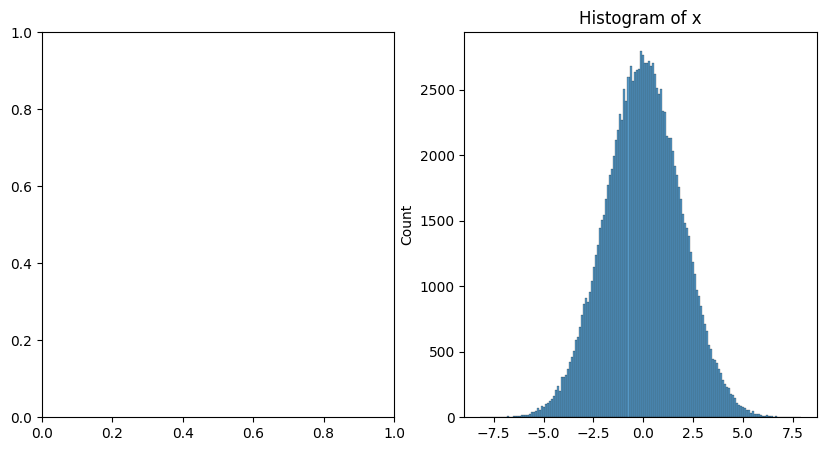

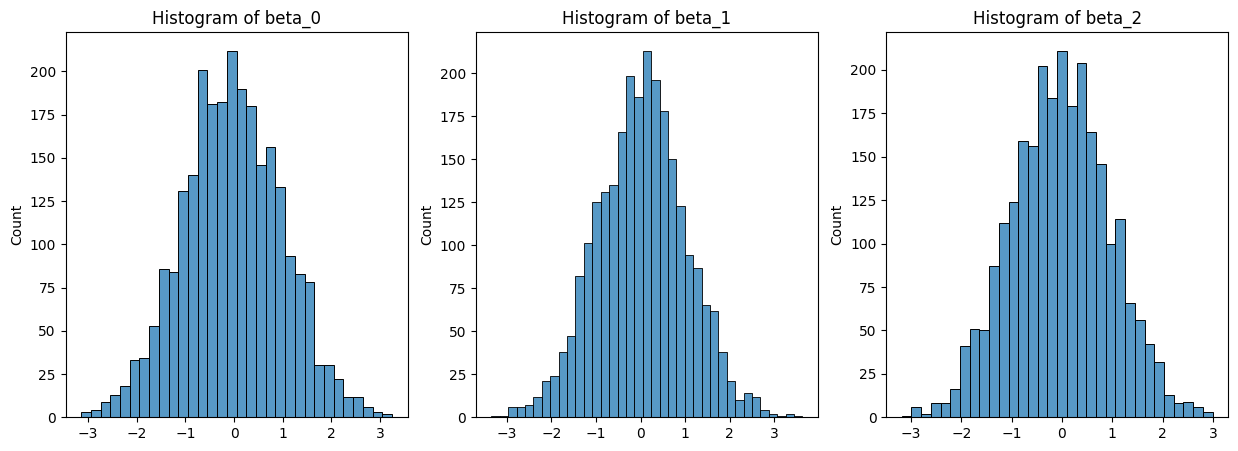

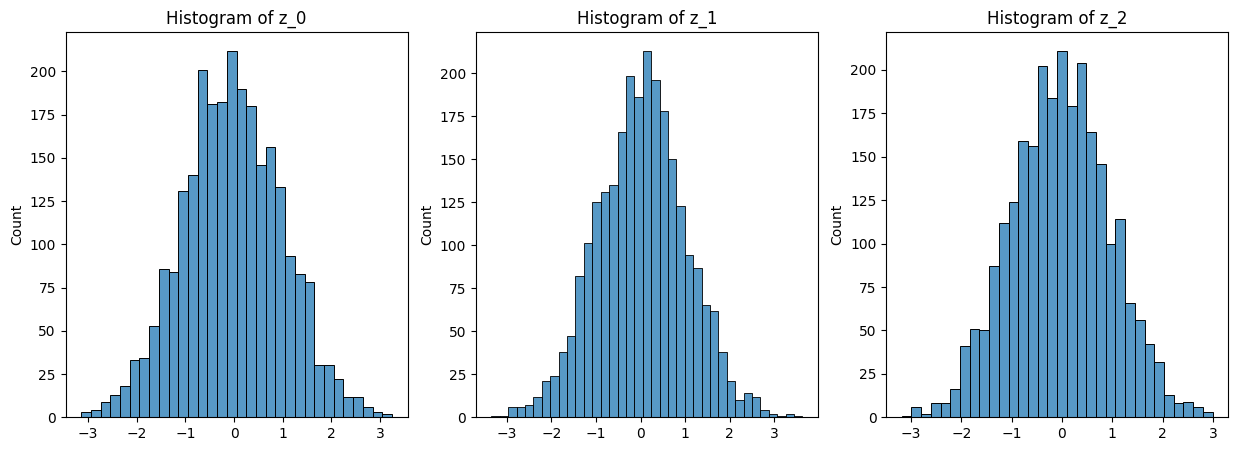

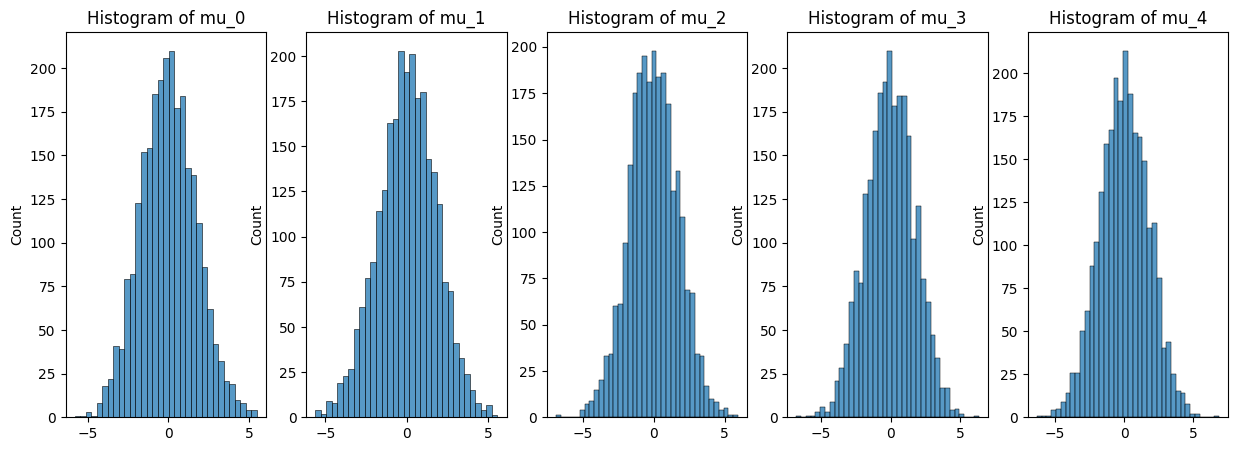

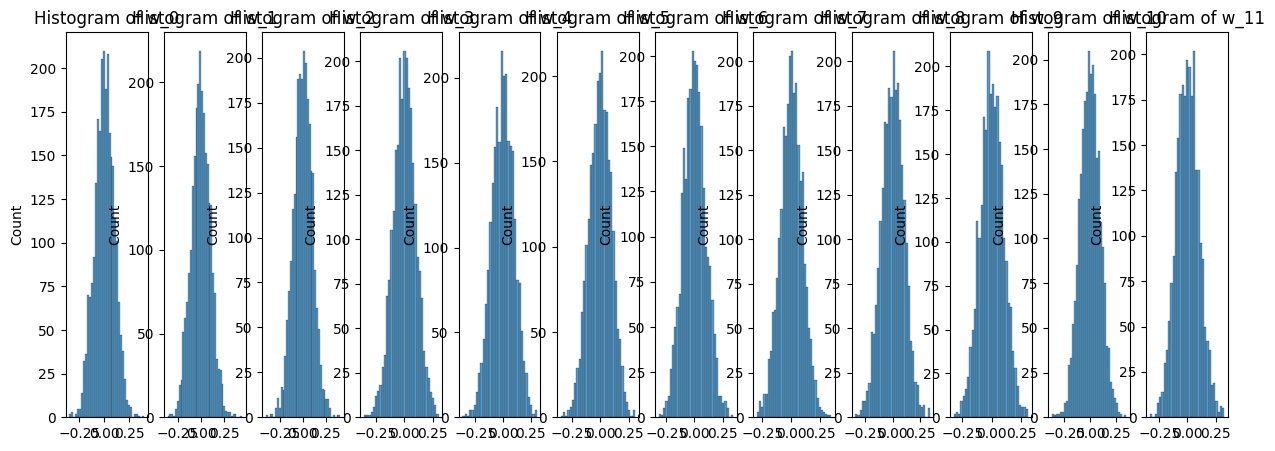

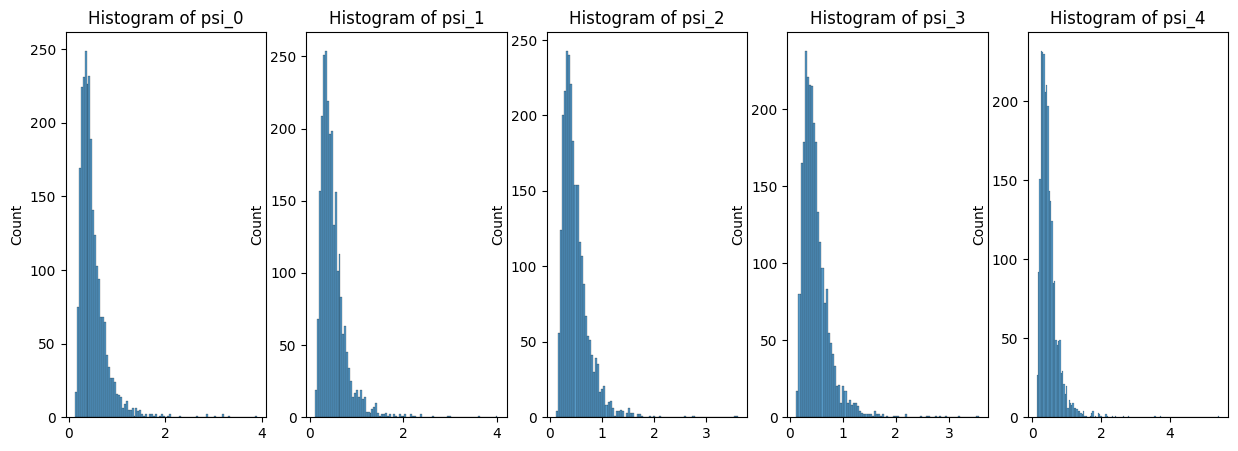

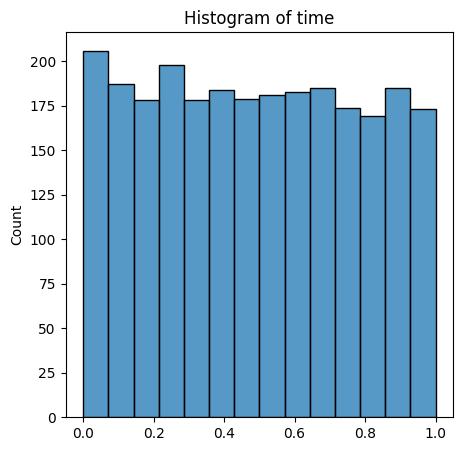

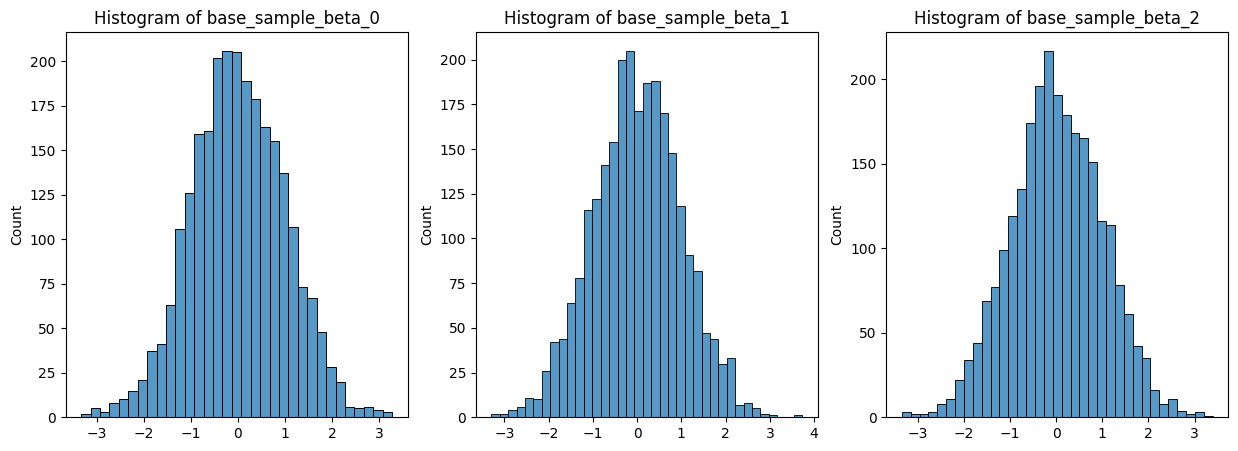

####################################################################################################
Epoch 99


100%|██████████| 10/10 [00:00<00:00, 43.64it/s]


{'X': {'mean': tensor(-0.0207), 'variance': tensor(3.5455), 'min': tensor(-8.1272), 'max': tensor(9.6828), 'mean_mean': tensor([-0.0463, -0.0004,  0.0070, -0.0706,  0.0068]), 'variance_mean': tensor([0.5086, 0.5046, 0.5077, 0.4919, 0.5035]), 'min_mean': None, 'max_mean': None}, 'beta': {'mean': tensor(-0.0121), 'variance': tensor(0.9987), 'min': tensor(-3.8742), 'max': tensor(3.5047), 'mean_mean': tensor(-0.0121), 'variance_mean': tensor(0.9999), 'min_mean': None, 'max_mean': None}}
Statistics for z:
Mean: tensor([-0.0353, -0.0049,  0.0038])
Variance: tensor([1.0142, 0.9693, 1.0126])
Min: tensor([-3.7155, -3.8522, -3.8742])
Max: tensor([3.5047, 3.3298, 2.9315])
Mean of means: -0.012133104726672173
Mean of variances: 0.9999359846115112
Mean of minimums: None
Mean of maximums: None


Statistics for mu:
Mean: tensor([-0.0458,  0.0051,  0.0084, -0.0736,  0.0015])
Variance: tensor([2.8431, 3.0973, 3.0309, 2.9709, 3.1959])
Min: tensor([-5.1865, -6.5618, -7.1826, -6.7427, -6.5504])
Max: tenso

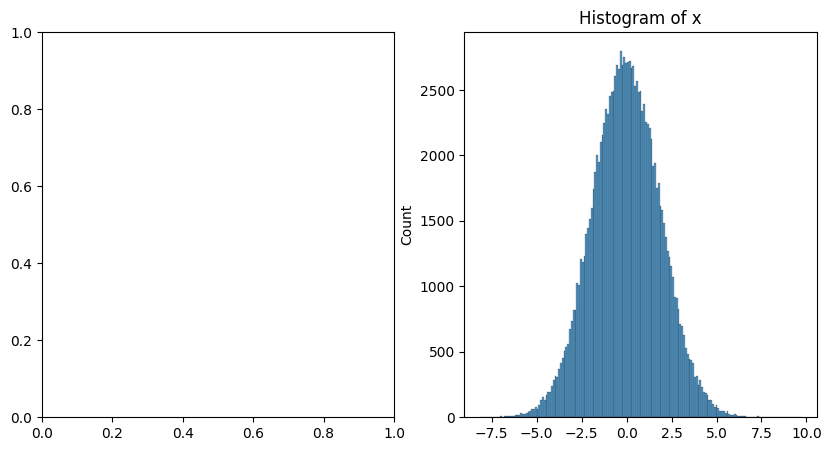

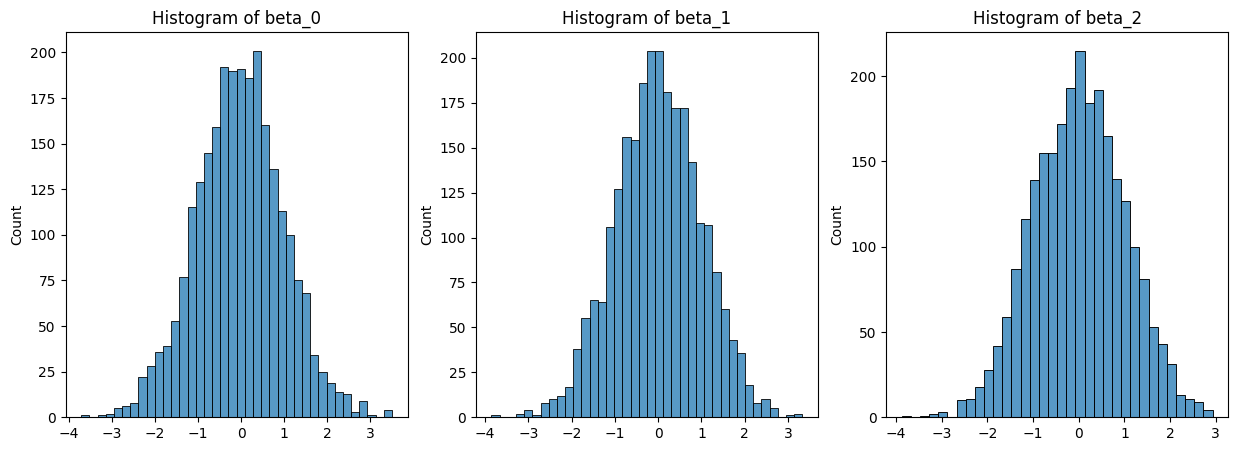

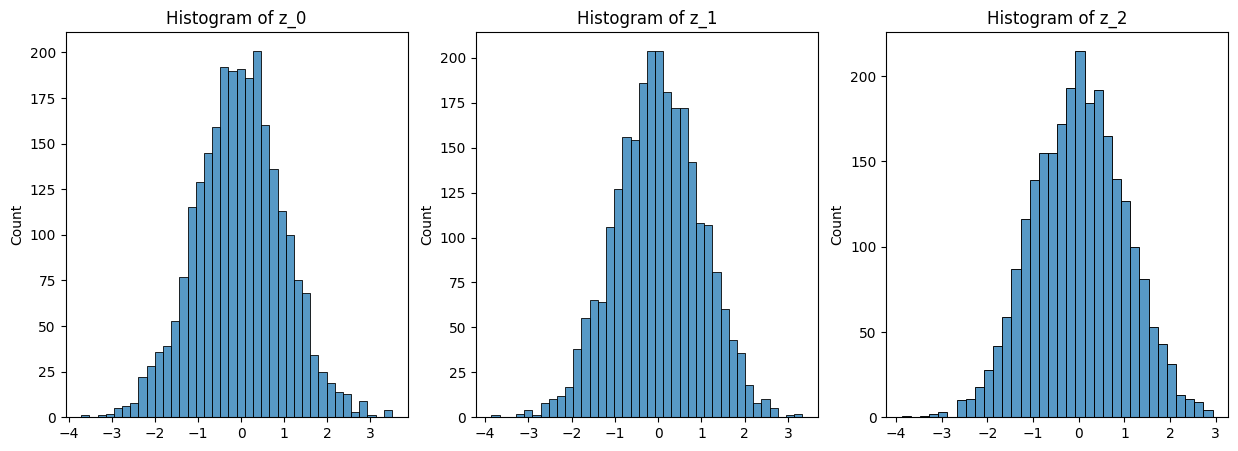

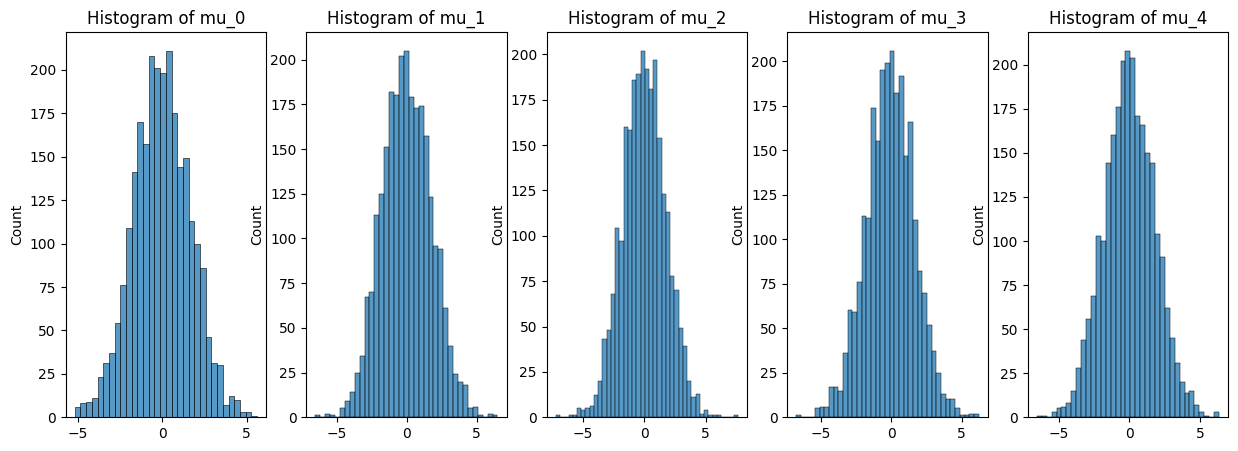

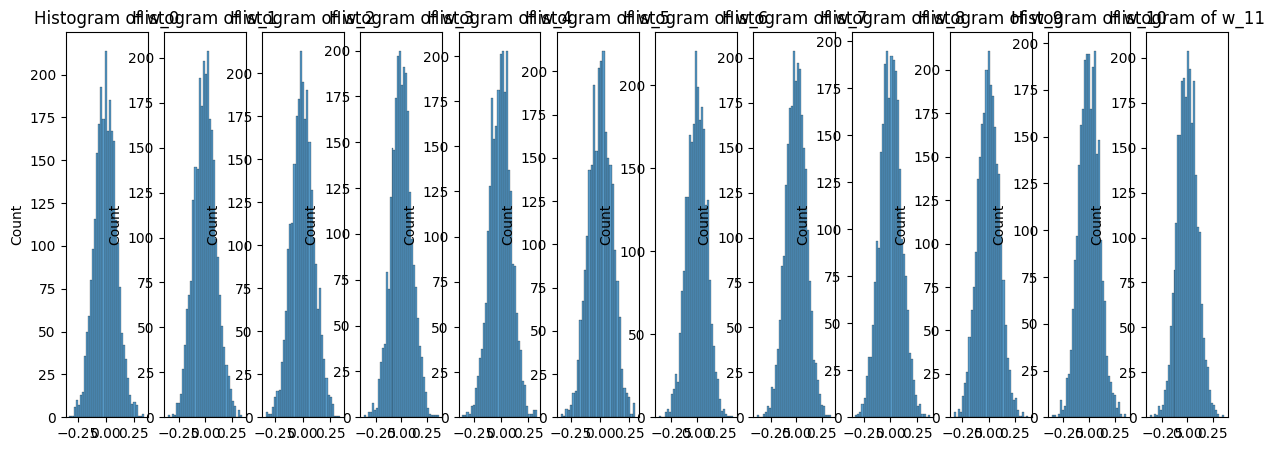

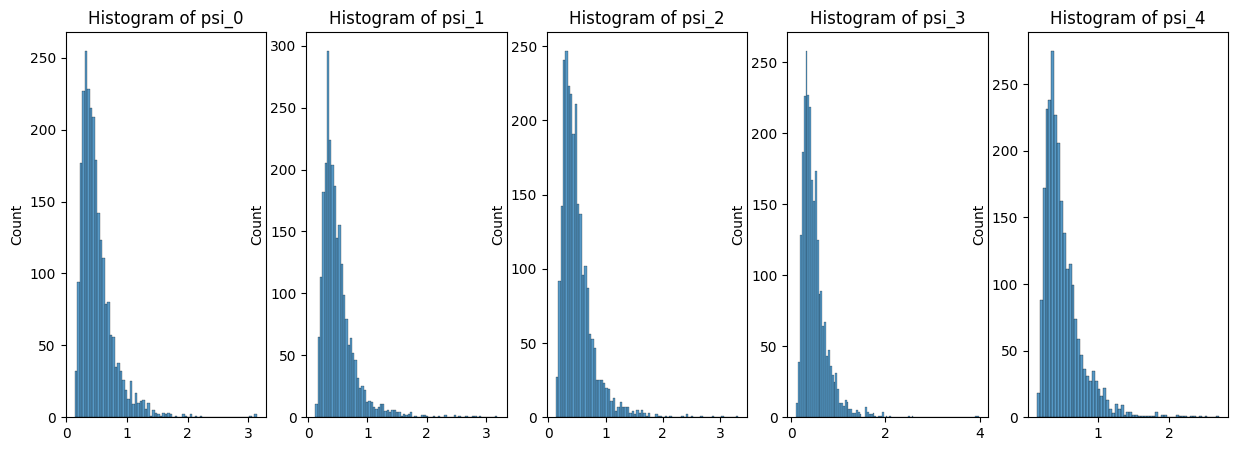

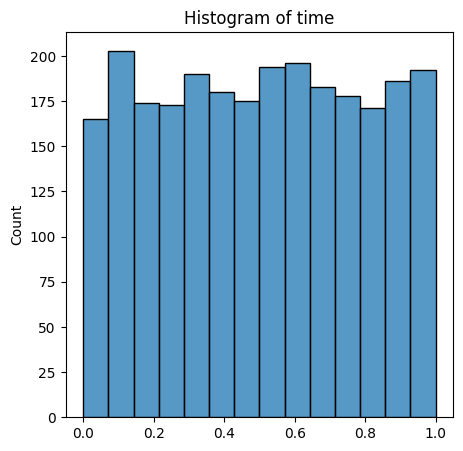

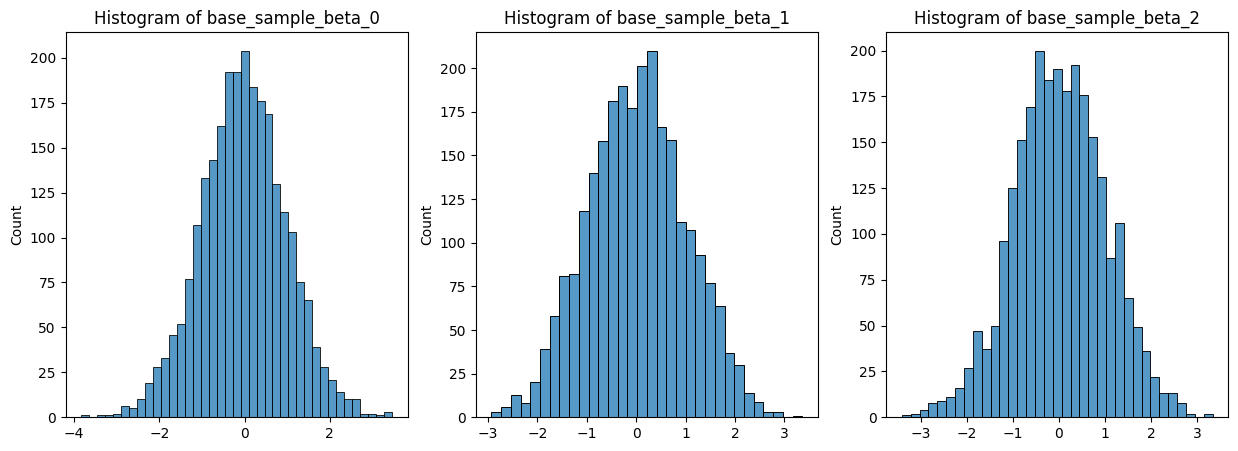

[{'X': {'mean': tensor(0.0032),
   'variance': tensor(3.5801),
   'min': tensor(-8.1681),
   'max': tensor(7.9034),
   'mean_mean': tensor([-0.0148,  0.0504, -0.0092, -0.0186,  0.0083]),
   'variance_mean': tensor([0.4943, 0.5019, 0.4836, 0.4850, 0.4930]),
   'min_mean': None,
   'max_mean': None},
  'beta': {'mean': tensor(-0.0113),
   'variance': tensor(0.9916),
   'min': tensor(-3.3470),
   'max': tensor(3.6335),
   'mean_mean': tensor(-0.0113),
   'variance_mean': tensor(0.9808),
   'min_mean': None,
   'max_mean': None}},
 {'X': {'mean': tensor(-0.0207),
   'variance': tensor(3.5455),
   'min': tensor(-8.1272),
   'max': tensor(9.6828),
   'mean_mean': tensor([-0.0463, -0.0004,  0.0070, -0.0706,  0.0068]),
   'variance_mean': tensor([0.5086, 0.5046, 0.5077, 0.4919, 0.5035]),
   'min_mean': None,
   'max_mean': None},
  'beta': {'mean': tensor(-0.0121),
   'variance': tensor(0.9987),
   'min': tensor(-3.8742),
   'max': tensor(3.5047),
   'mean_mean': tensor(-0.0121),
   'variance_

In [10]:
data_generator.check_model(
    n_samples_per_epoch=N_SAMPLES_PER_EPOCH,
    epochs_to_check = [0, N_EPOCHS-1],
    p = P,
    n = N,
    used_batch_samples = 10
)

In [11]:
epoch_loader = data_generator.make_epoch_loader(
    n = N,
    p = P,
    number_of_batches_per_epoch = N_BATCHES_PER_EPOCH,
    n_epochs = N_EPOCHS,
    batch_size= BATCH_SIZE,
    train_frac= 0.5,
    val_frac= 0.1,
    shuffle=False,
    n_samples_to_generate_at_once = 250_000
)

The number of batches times the number of epochs must be equal to the total number of iterations in the curriculum. But got 49971200 and 24985600 respectively


In [12]:
sample_batch = next(iter(epoch_loader[0][0]))
sample_batch.keys()

dict_keys(['x', 'z', 'mu', 'w', 'psi', 'beta', 'time', 'base_sample_beta'])

In [13]:
sample_batch["x"].shape, sample_batch["beta"].shape

(torch.Size([1024, 10, 5]), torch.Size([1024, 3]))

In [14]:
2*K

6

In [15]:
"""
model = TransformerCNFConditionalDecoder(
    n_input_features_encoder = 1,
    n_input_features_decoder = 2*P,
    d_model_encoder = 512,
    d_model_decoder = 512,
    n_heads_encoder = 8,
    n_heads_decoder = 8,
    d_ff_encoder = 1024,
    d_ff_decoder = 1024,
    dropout_encoder = 0.1,
    dropout_decoder = 0.1,
    n_conditional_input_features =  1,
    n_condition_features = 512,
    n_layers_condition_embedding = 3,
    n_layers_encoder = 8,
    n_layers_decoder = 6,
    use_positional_encoding_encoder = True,
    use_positional_encoding_decoder = False,
    use_self_attention_decoder = False,
    output_dim = 2*P,
    d_final_processing = 512,
    n_final_layers = 3,
    dropout_final = 0.1,
    treat_z_as_sequence = False,
)
"""

model = TransformerCNFConditionalDecoder(
    n_input_features_encoder = P,
    n_input_features_decoder = K,
    d_model_encoder = 16,
    d_model_decoder = 16,
    n_heads_encoder = 1,
    n_heads_decoder = 1,
    d_ff_encoder = 16,
    d_ff_decoder = 16,
    dropout_encoder = 0.1,
    dropout_decoder = 0.1,
    n_conditional_input_features =  1,
    n_condition_features = 16,
    n_layers_condition_embedding = 3,
    n_layers_encoder = 8,
    n_layers_decoder = 6,
    use_positional_encoding_encoder = True,
    use_positional_encoding_decoder = False,
    use_self_attention_decoder = False,
    output_dim = K,
    d_final_processing = 16,
    n_final_layers = 3,
    dropout_final = 0.1,
    treat_z_as_sequence = False,
)

In [16]:
loss_fun = CFMLossOT2(
    sigma_min=1e-4
)

In [17]:
opt = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = OneCycleLR(opt,
                       max_lr = 5e-4,
                       epochs = N_EPOCHS,
                       steps_per_epoch = N_SAMPLES_PER_EPOCH//BATCH_SIZE,
                       pct_start = 0.1,
                       div_factor=25.0,
                       final_div_factor=1e4)

#scheduler = ReduceLROnPlateau(opt)

additional_evals = {
}



In [29]:
trainer = TrainerCurriculumCNF_LatentFactor(
    model = model,
    optimizer=opt,
    scheduler = scheduler,
    loss_function=loss_fun,
    epoch_loader = epoch_loader,
    evaluation_functions= additional_evals,
    n_epochs = N_EPOCHS,
    early_stopping_patience = 200,
    schedule_step_on = "batch",
    save_path = None,
    coupling = None,
    use_same_timestep_per_batch = False,
    use_train_mode_during_validation = False,
    max_gradient_norm = 1.0

)

In [30]:
trainer.validate()

100%|██████████| 49/49 [00:17<00:00,  2.86it/s]


{'loss_mean': 2.0202736854553223,
 'loss_median': 2.0186054706573486,
 'loss_std': 0.046270422637462616}

In [31]:
r = trainer.train()

Curriculum parameters: {'n': 10, 'p': 5, 'batch_size': 1024, 'z_dim': 3, 'w_var': 0.1, 'mu_var': 3.0, 'a1_psi_var': 5.0, 'b1_psi_var': 2.0} at iteration 0


100%|██████████| 49/49 [00:13<00:00,  3.69it/s]


Epoch 0:
Training: {'loss_mean': 2.5788094997406006, 'loss_median': 2.570557117462158, 'loss_std': 0.13627026975154877}
Validation: {'loss_mean': 2.1075072288513184, 'loss_median': 2.105250835418701, 'loss_std': 0.055805351585149765}
Validation curriculum: {'loss_mean': 2.1117348670959473, 'loss_median': 2.1092641353607178, 'loss_std': 0.057302478700876236}
Time: 118.50474262237549
Learning rate: [2.2956007119594385e-05]


----------------------------------------------------------------------------------------------------
Saving model
Curriculum parameters: {'n': 10, 'p': 5, 'batch_size': 1024, 'z_dim': 3, 'w_var': 0.1, 'mu_var': 3.0, 'a1_psi_var': 5.0, 'b1_psi_var': 2.0} at iteration 249856


  0%|          | 0/244 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [73]:
full_model = ModelToPosteriorCNF(
    model = model.eval(),
    sample_name = "beta",
    sample_shape = (K,),
    n_samples=1000,
    batch_size = BATCH_SIZE,
    solve_adjoint = True,
    atol = 10,
    rtol = 10,
    #device = torch.device("cpu")
)

benchmark_params_ppgrogram = data_generator.curriculum.get_params(-1)
del benchmark_params_ppgrogram["batch_size"]
print(f"params for pprogram: {benchmark_params_ppgrogram}")

pprogram1 = make_fa_program_normal_weight_prior(**benchmark_params_ppgrogram)

pprogram1_x = return_only_x(pprogram1)



params for pprogram: {'n': 10, 'p': 5, 'z_dim': 3, 'w_var': 0.1, 'mu_var': 3.0, 'a1_psi_var': 5.0, 'b1_psi_var': 2.0}


In [74]:
test_batch = next(iter(epoch_loader[0][1]))
x_test = test_batch["x"]

In [75]:
x_test.shape

torch.Size([1024, 10, 5])

In [76]:
samples = full_model.sample_posterior(x_test[0])

0it [00:00, ?it/s]


In [77]:
samples["beta"].shape

torch.Size([1000, 3])

In [78]:
hmc = Hamiltionian_MC(
    pprogram=pprogram1_x,
    n_samples=500,
    n_warmup=500
)

models = make_default_list_comparison(pprogram= pprogram1_x, n_samples= 1000, discrete_z=False)

In [79]:
models

[Hamiltonian Monte Carlo,
 Variational Inference with guide: AutoDiagonalNormal(),
 Variational Inference with guide: AutoMultivariateNormal(),
 Variational Inference with guide: AutoLaplaceApproximation(),
 Variational Inference with guide: AutoIAFNormal(),
 Variational Inference with guide: AutoStructured()]

In [80]:
"""
evaluation = Evaluate(
    posterior_model = full_model,
    evaluation_loader = trainer.testset,
    comparison_models= [hmc],
    n_evaluation_cases=2,
    save_path= None,
    overwrite_results = True,
    results_dict_to_data_for_model = results_dict_to_data_x_tuple,
    results_dict_to_latent_variable_comparison_models= result_dict_to_latent_variable_convert_z_to_beta,
    result_dict_to_data_for_comparison_models= results_dict_to_data_x_tuple
)
"""

evaluation = Evaluate(
    posterior_model = models[1],
    evaluation_loader = trainer.testset,
    comparison_models= [hmc],
    n_evaluation_cases=2,
    save_path= None,
    overwrite_results = True,
    results_dict_to_data_for_model = results_dict_to_data_x_tuple,
    results_dict_to_latent_variable_posterior_model = result_dict_to_latent_variable_convert_z_to_beta,
    results_dict_to_latent_variable_comparison_models= result_dict_to_latent_variable_convert_z_to_beta,
    result_dict_to_data_for_comparison_models= results_dict_to_data_x_tuple
)

In [81]:
evaluation.run_evaluation()

....................


Warmup:   0%|          | 0/1000 [15:37, ?it/s]


....................


 49%|████▉     | 49/100 [00:00<00:00, 483.04it/s]

An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_sam

100%|██████████| 100/100 [00:00<00:00, 451.90it/s]


An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.


100%|██████████| 100/100 [00:00<00:00, 518.33it/s]

An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_sam

Comparison to ground truth:

Summarized results:


,Model,GT,Mean_joint_Wasserstein_distance with metric euclidean,Mean_joint_MMD,Mean_joint_cst_roc_auc,Mean_gt_parameter_Perplextiy,Mean_gt_parameter_MAP diff,Mean_gt_parameter_Mean diff,Std_joint_Wasserstein_distance with metric euclidean,Std_joint_MMD,Std_joint_cst_roc_auc,Std_gt_parameter_Perplextiy,Std_gt_parameter_MAP diff,Std_gt_parameter_Mean diff
0,Variational Inference with guide: AutoDiagonal...,gt,16.690027,2.212885,NaN,-2.407008,0.396862,0.415965,0.066100,0.012948,NaN,0.066862,0.040612,0.019893
1,Hamiltonian Monte Carlo,gt,16.799424,2.226775,NaN,-3.059754,0.331728,0.404114,0.178542,0.025503,NaN,0.074782,0.014760,0.087002


P-values:


,Model 1,Model 2,joint_Wasserstein_distance with metric euclidean_p-value,joint_MMD_p-value,joint_cst_roc_auc_p-value,gt_parameter_Perplextiy_p-value,gt_parameter_MAP diff_p-value,gt_parameter_Mean diff_p-value
0,Variational Inference with guide: AutoDiagonal...,Hamiltonian Monte Carlo,0.5,0.5,NaN,0.5,0.5,1.0



Comparison among models:

Summarized results:


,Model 1,Model 2,Mean_Wasserstein_distance with metric euclidean,Mean_MMD,Mean_cst_roc_auc,Std_Wasserstein_distance with metric euclidean,Std_MMD,Std_cst_roc_auc
0,Variational Inference with guide: AutoDiagonal...,Hamiltonian Monte Carlo,0.520702,0.117461,0.584,0.008717,0.005159,0.0


P-values:


""


{'summarized_results': {'comparison_to_gt':                                                Model  GT  \
  0  Variational Inference with guide: AutoDiagonal...  gt   
  1                            Hamiltonian Monte Carlo  gt   
  
     Mean_joint_Wasserstein_distance with metric euclidean  Mean_joint_MMD  \
  0                                          16.690027            2.212885   
  1                                          16.799424            2.226775   
  
     Mean_joint_cst_roc_auc  Mean_gt_parameter_Perplextiy  \
  0                     NaN                     -2.407008   
  1                     NaN                     -3.059754   
  
     Mean_gt_parameter_MAP diff  Mean_gt_parameter_Mean diff  \
  0                    0.396862                     0.415965   
  1                    0.331728                     0.404114   
  
     Std_joint_Wasserstein_distance with metric euclidean  Std_joint_MMD  \
  0                                           0.066100          0.012948   

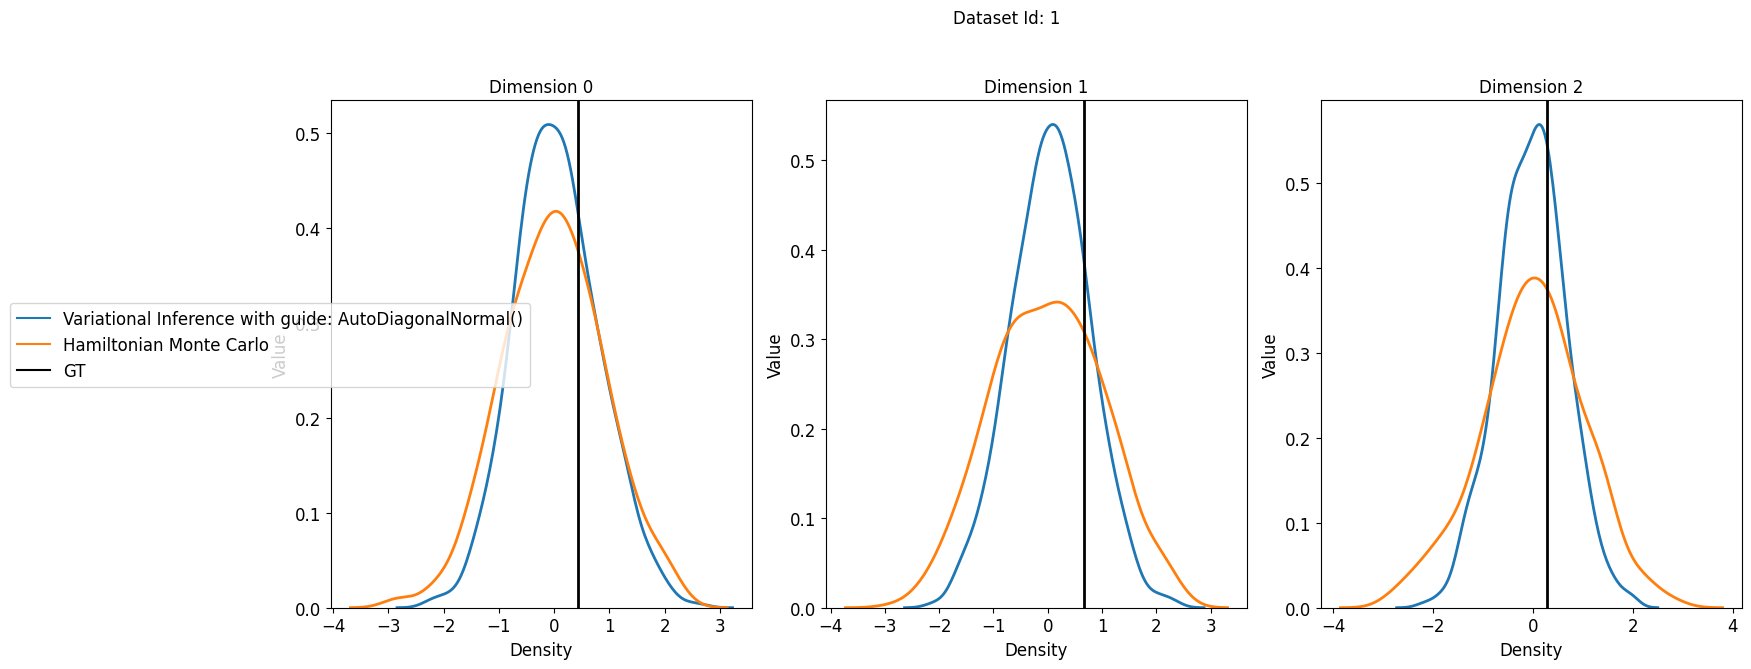

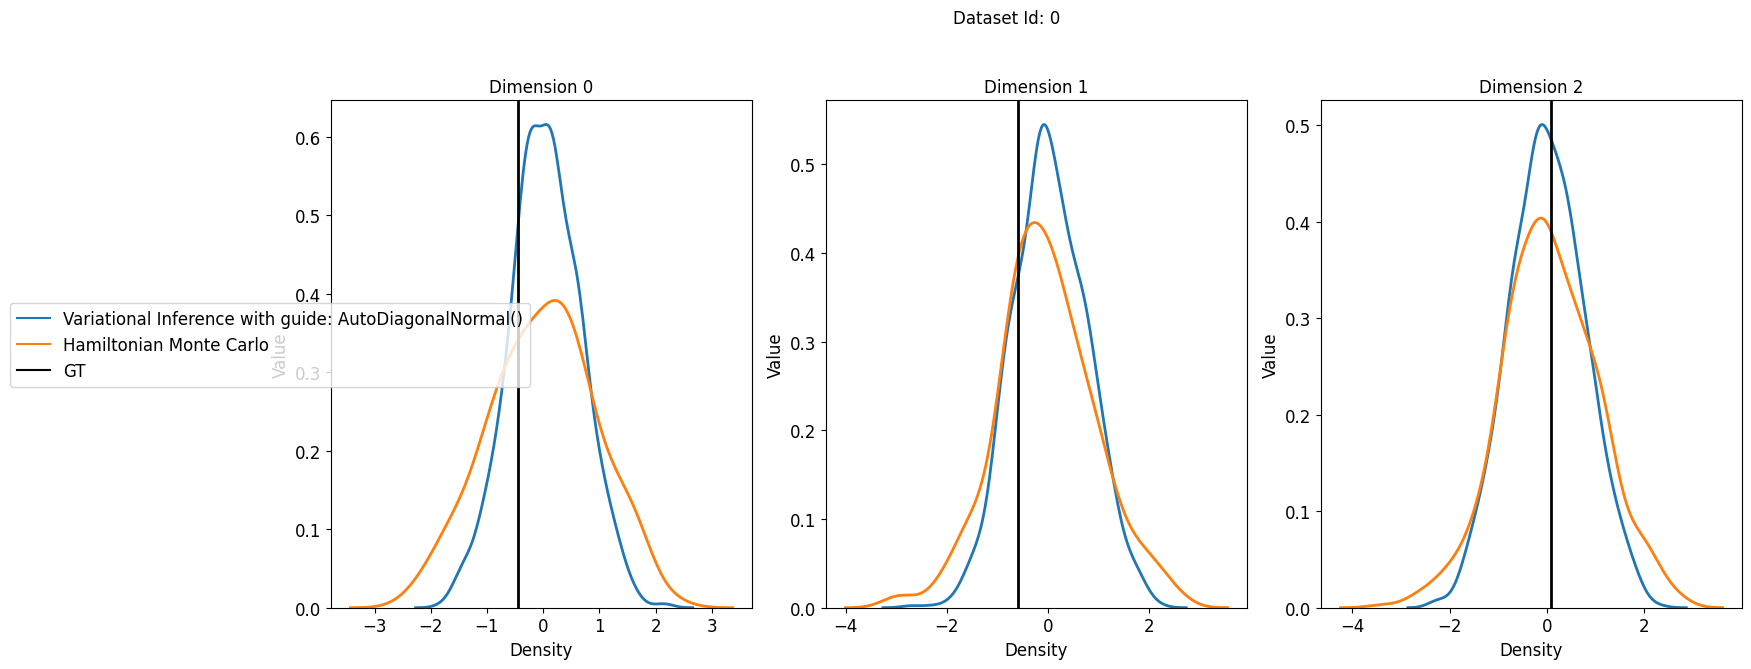

In [82]:
evaluation.plot_results()

In [83]:
from PFNExperiments.Evaluation.RealWorldEvaluation.PreprocessDataset import Preprocessor, PreprocessorClassification

In [84]:
from PFNExperiments.Evaluation.RealWorldEvaluation.Preprocess_multivariate_GMM import Preprocessor_GMM_multivariate
from PFNExperiments.Evaluation.RealWorldEvaluation.GetDataOpenML import GetDataOpenML
getdata = GetDataOpenML(
    preprocessor = Preprocessor_GMM_multivariate(
        N_datapoints = N,
        P_features = P,
        x_mean = 0.0,
        x_var = 1.0,
    ),
    save_path = "C:/Users/arik_/Documents/Dokumente/Job_Clausthal/PFNs/Repository/PFNExperiments/Evaluation/RealWorldEvaluation/DatasetsOpenML/Tabular_benchmark_numerical_regression.pkl",
    benchmark_id = 336
)
datasets = getdata.get_data()

In [85]:
from PFNExperiments.Evaluation.RealWorldEvaluation.EvaluateRealWorld import EvaluateRealWorld


eval = EvaluateRealWorld(
    
    posterior_model = full_model,
    evaluation_datasets = datasets,
    comparison_models = [models[1]],
    n_evaluation_cases = 2,
    results_dict_to_data_for_model = results_dict_to_data_x_tuple,
    results_dict_to_latent_variable_comparison_models= result_dict_to_latent_variable_convert_z_to_beta,
    result_dict_to_data_for_comparison_models= results_dict_to_data_x_tuple
)

In [86]:
eval.run_evaluation()

Sampling posterior:   0%|          | 0/2 [00:00<?, ?it/s]

....................


Sampling posterior:  50%|█████     | 1/2 [00:21<00:21, 21.23s/it]

....................


Sampling posterior: 100%|██████████| 2/2 [00:40<00:00, 20.46s/it]


Comparison to ground truth:

Summarized results:

Comparison among models:

Summarized results:


,Model 1,Model 2,Mean_Wasserstein_distance with metric euclidean,Mean_MMD,Mean_cst_roc_auc,Std_Wasserstein_distance with metric euclidean,Std_MMD,Std_cst_roc_auc
0,<PFNExperiments.LinearRegression.Models.ModelT...,Variational Inference with guide: AutoDiagonal...,1.355486e+10,7.742189,1.0,2.004970e+07,0.0,0.0


P-values:


""


{'summarized_results': {'model_comparison_among_each_other':                                              Model 1  \
  0  <PFNExperiments.LinearRegression.Models.ModelT...   
  
                                               Model 2  \
  0  Variational Inference with guide: AutoDiagonal...   
  
     Mean_Wasserstein_distance with metric euclidean  Mean_MMD  \
  0                                     1.355486e+10  7.742189   
  
     Mean_cst_roc_auc  Std_Wasserstein_distance with metric euclidean  Std_MMD  \
  0               1.0                                    2.004970e+07      0.0   
  
     Std_cst_roc_auc  
  0              0.0  },
 'test_results': {'model_comparison_among_each_other': Empty DataFrame
  Columns: []
  Index: []},
 'res_df': {'model_comparison_among_each_other': {('<PFNExperiments.LinearRegression.Models.ModelToPosteriorCNF.ModelToPosteriorCNF object at 0x000001F0C21AC1F0>',
    'Variational Inference with guide: AutoDiagonalNormal()'):    Wasserstein_distance wit